## Hualien Earthquake Project

In [7]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
import scipy.signal as signal
from scipy.signal import stft
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
import folium
import json
import requests

### Seismology

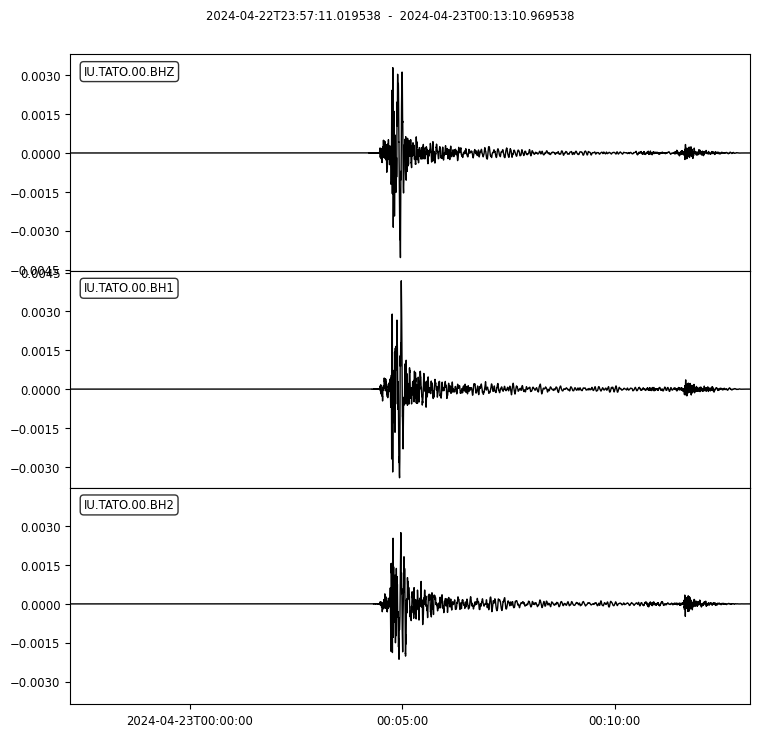

In [11]:
client = Client('IRIS')
time = UTCDateTime('2024-04-22T23:58:11')
starttime = time - 60
endtime = time + 60*15
net='IU'; sta='TATO'; loc='00'; chan='BH*'
Z = client.get_waveforms(net,sta,loc,chan, starttime, endtime, attach_response=True)
Z.remove_response(output='VEL')
Z.merge();Z.detrend(type='linear')
Z.taper(max_percentage=0.05)
Z.plot();

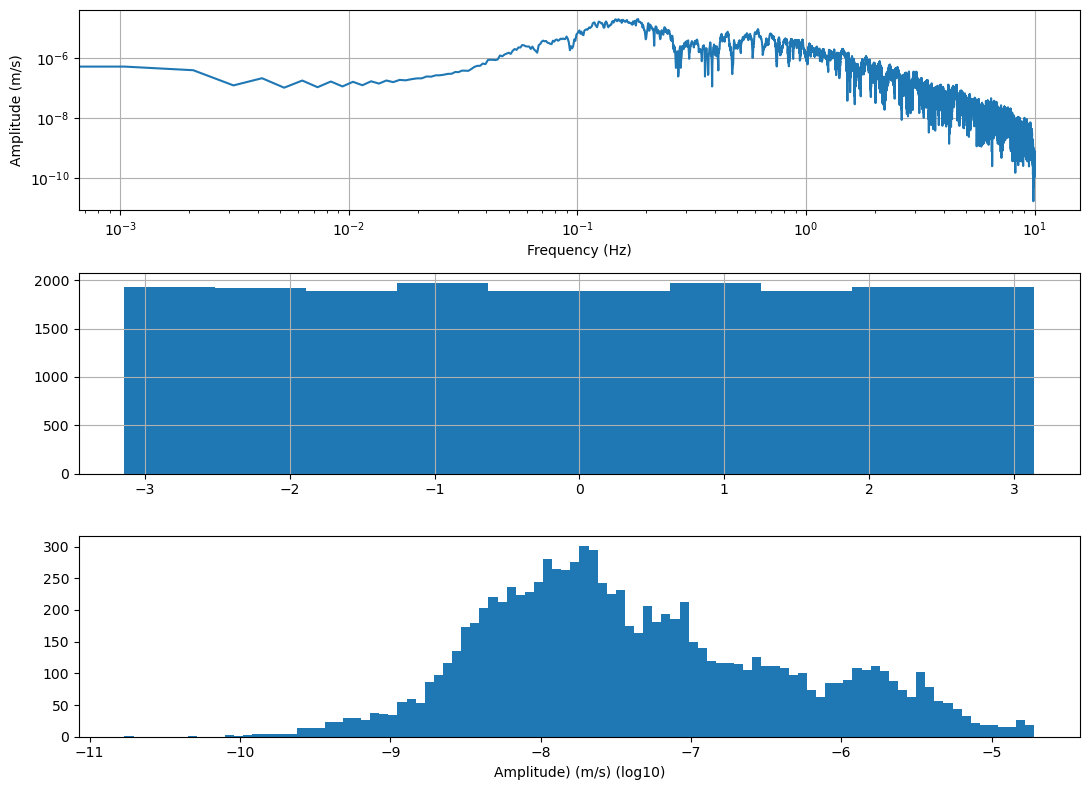

In [63]:
npts = Z[0].stats.npts
Nfft = next_fast_len(int(Z[0].data.shape[0]))
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat =  fft(Z[0].data, n=Nfft)

fig, ax = plt.subplots(3, 1, figsize=(11, 8))
ax[0].plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)
ax[2].hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100)
ax[2].set_xlabel('Amplitude) (m/s) (log10)')
plt.tight_layout()


0.00029237370747945763
1.831737492449356e-12


<function matplotlib.pyplot.show(close=None, block=None)>

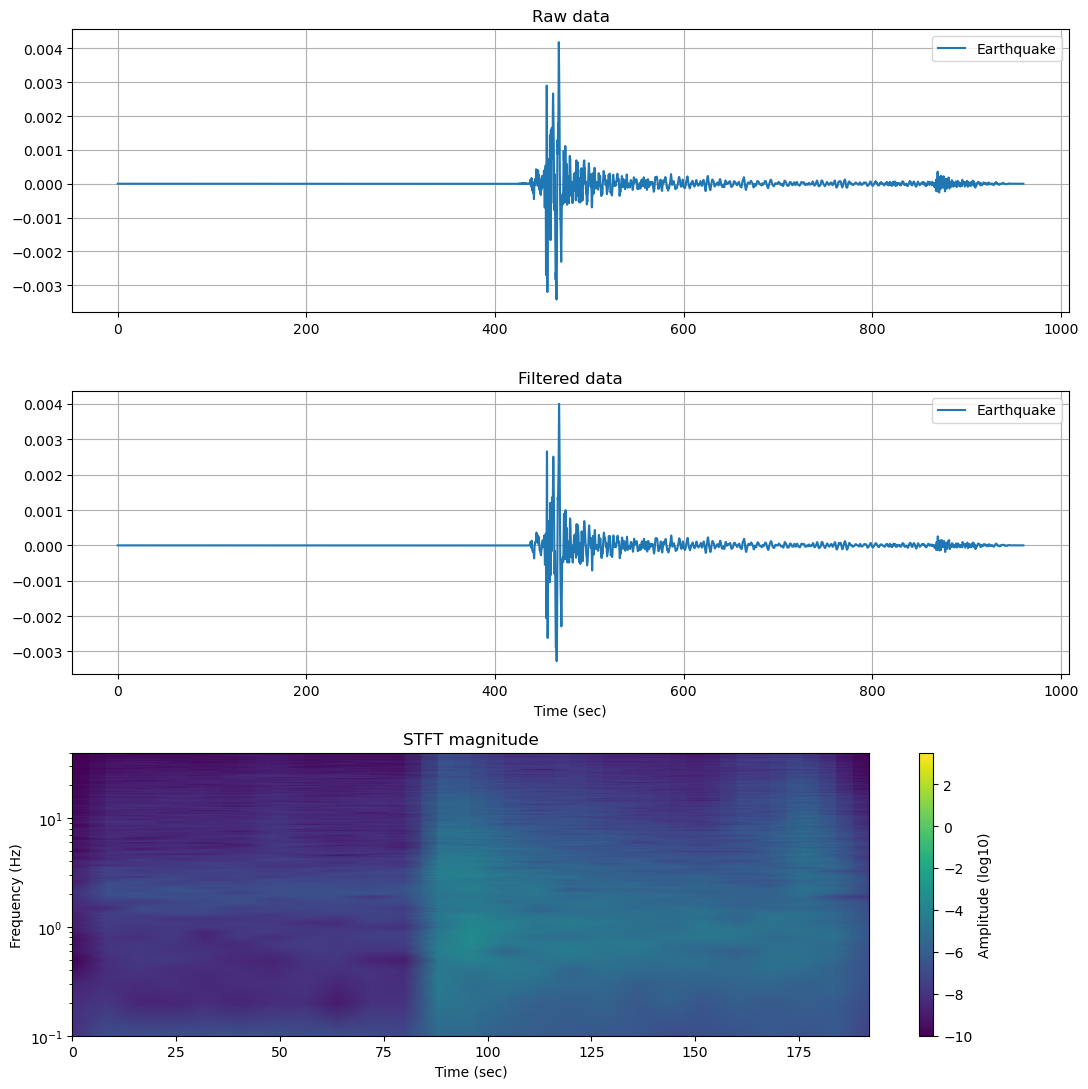

In [61]:
# Z as an ObsPy trace object
fs = Z[0].stats.sampling_rate
Z_ = np.asarray(Z[0].data)

# filter the data
sos = signal.butter(2,[1./150.,1.],'bp', fs=fs,output='sos')
Zf = signal.sosfilt(sos,Z_)
t = np.arange(0, len(Z_)) / fs

# STFT
nperseg = 1000
f,t_,Zxx = stft(Z_, fs=100, nperseg=nperseg, noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
print(np.min(np.min(np.abs(Zxx))))

# plotting
# raw data
fig, ax = plt.subplots(3,1,figsize = (11,11))
ax[0].plot(t,Z_); ax[0].grid(True)
ax[0].set_title('Raw data'); ax[0].legend(['Earthquake'])

# filtered data
ax[1].plot(t,Zf); ax[1].grid(True)
ax[1].set_title('Filtered data'); ax[1].legend(['Earthquake'])
ax[1].set_xlabel('Time (sec)')

# STFT magnitude
pcm = ax[2].pcolormesh(t_, f,np.log10(np.abs(Zxx)),vmin=-10,vmax=3.5,shading='gouraud')
ax[2].set_title('STFT magnitude')
ax[2].set_xlabel('Time (sec)'); ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_yscale('log'); ax[2].set_ylim(0.1, 40)

cbar = fig.colorbar(pcm, ax=ax[2])
cbar.set_label('Amplitude (log10)')

plt.tight_layout()
plt.show


In [17]:
# Moment rate data from https://earthquake.usgs.gov/earthquakes/eventpage/us7000m9g4/finite-fault
url = 'https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/47c400702cc341d69964b2ff2cd9a7f40726df5c/moment_rate.mr'
mr = pd.read_csv(url, header=None, delim_whitespace=True, names=['Time', 'MR'], skiprows=2)
print(mr)

       Time            MR
0      0.00  0.000000e+00
1      0.01  4.427200e+11
2      0.02  2.213400e+12
3      0.03  6.196800e+12
4      0.04  1.327600e+13
...     ...           ...
6896  68.96  0.000000e+00
6897  68.97  0.000000e+00
6898  68.98  0.000000e+00
6899  68.99  0.000000e+00
6900  69.00  0.000000e+00

[6901 rows x 2 columns]


Max moment rate =  1.1741e+19 Nm/s


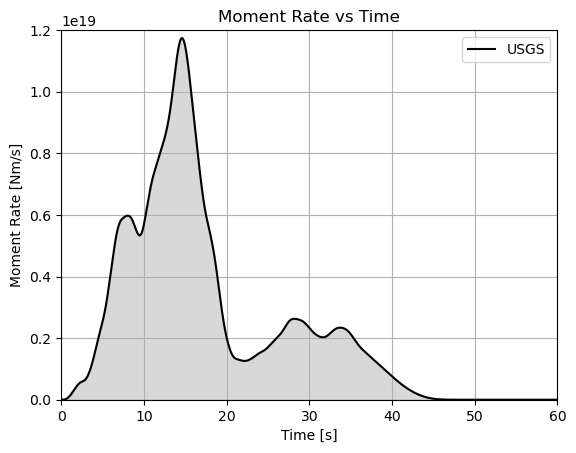

In [32]:
fig = plt.figure()
max_MR = mr['MR'].max()
print('Max moment rate = ', max_MR, 'Nm/s')
plt.plot(mr.Time, mr.MR, label="USGS", c='black')
plt.xlim(0,60)
plt.ylim(0,1.2e19)
plt.fill_between(mr['Time'], mr['MR'], color='gray', alpha=0.3)  # Fill area under the curve with gray
plt.legend(loc="upper right")
plt.title('Moment Rate vs Time')
plt.xlabel("Time [s]")
plt.ylabel("Moment Rate [Nm/s]")
plt.grid(True)
plt.show()

In [29]:
# Find the start time when mr.MR = 0
start_time_zero_MR = mr.loc[mr['MR'] == 0, 'Time'].iloc[1]
print("Start time when MR = 0:", start_time_zero_MR, "s")

Start time when MR = 0: 48.79 s


In [36]:
# Calculate the time step (assuming uniform time intervals)
dt = mr.Time.diff().mean()
# Integrate the moment rate with respect to time using the trapezoidal rule
area_under_curve = np.trapz(mr.MR, dx=dt)
M0 = area_under_curve
print("M0:", M0, "Nm")


M0: 1.4392766715855176e+20 Nm


By the empirical relationship, $M_w = \frac{2}{3}(log_{10}{M_0}-9.1)$

In [39]:
Mw = (2/3)*(np.log10(M0)-9.1)
print("Mw:", Mw)

Mw: 7.372096190812169


In [10]:
# # URL to the GeoJSON file
# usgs_url = 'https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/1b30a34ac6e12d01286c7c1f6e80c16048125c12/FFM.geojson'

# # Fetch the GeoJSON data
# response = requests.get(usgs_url)
# data = response.json()

# # Create a map centered at a location
# m = folium.Map(location=[23.75, 121.0], zoom_start=8)

# # Add each feature in the GeoJSON data to the map
# for feature in data['features']:
#     folium.GeoJson(feature).add_to(m)

# # Display the map
# m


In [43]:
# GEM Global Active Faults Database (GEM GAF-DB) from Styron et al., 2020
active_faults_url = 'https://raw.githubusercontent.com/GEMScienceTools/gem-global-active-faults/master/gmt/gem_active_faults_harmonized.gmt'

# Bird, P. (2003) An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027, doi:10.1029/2001GC000252.
plate_boundaries_url = 'http://peterbird.name/oldFTP/PB2002/PB2002_boundaries.dig.txt'

# HUA3 gps station from http://geodesy.unr.edu/NGLStationPages/stations/HUA3.sta
gps_url = 'http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/HUA3.tenv3'

#tshi, thep, thua tide gauge stations from Intergovernmental Oceanographic Commission (IOC).

### Geodesy

In [20]:
tshi = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=tshi')[8]
thep =  pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=thep')[8]
thua =  pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=thua')[8]

In [44]:
gps = pd.read_csv(gps_url, sep='\s+')

M 7.4 - 15 km S of Hualien City, Taiwan

- April 2, 2024: 2024.2521
- 23:58:12 (UTC)
- 23.835°N 121.598°E at 40.0 km depth



/var/folders/vn/yw43vwrj3nsglb002nc_3s6w0000gn/T/ipykernel_38223/4254573210.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


The Mw 7.4 Hualien earthquake has caused 
a westward motion of -2.22 cm 
a southward motion of 8.02 cm 
an uplift of 42.75 cm 
at the GPS station HUA3.


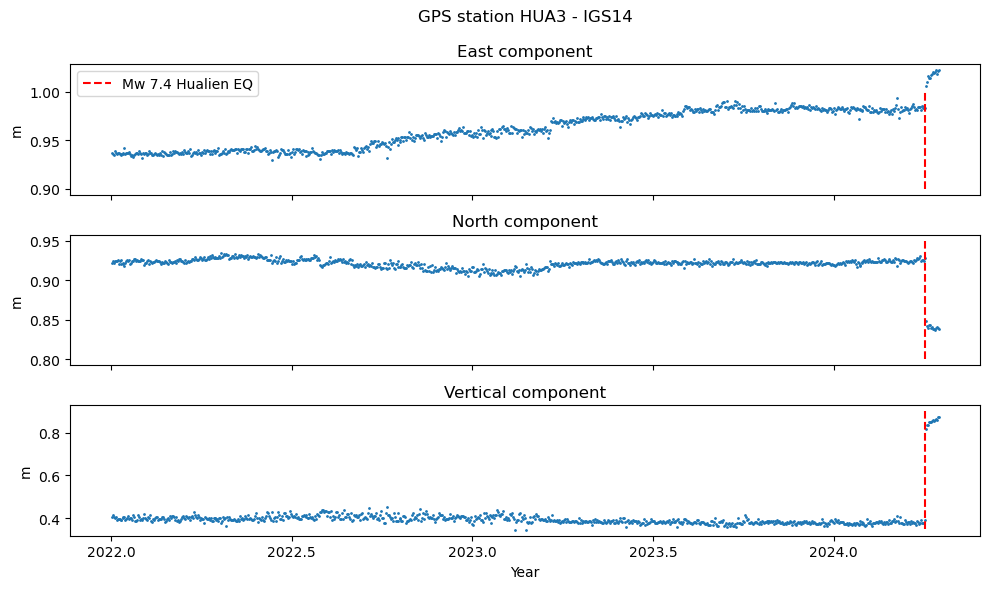

In [81]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex = True)

recent_gps = gps[gps['yyyy.yyyy'] >= 2022.0]

event = 2024.2521
ax[0].set_title("GPS station HUA3 - IGS14\n\nEast component")
ax[0].plot(recent_gps['yyyy.yyyy'], recent_gps['__east(m)'], 'o', markersize=1)
ax[0].set_ylabel("m")
ax[0].vlines(x=event, ymin=0.9, ymax=1.0, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')
ax[0].legend(loc="upper left")

ax[1].set_title("North component")
ax[1].plot(recent_gps['yyyy.yyyy'], recent_gps['_north(m)'], 'o', markersize=1)
ax[1].set_ylabel("m")
ax[1].vlines(x=event, ymin=0.8, ymax=0.95, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

ax[2].set_title("Vertical component")
ax[2].plot(recent_gps['yyyy.yyyy'], recent_gps['____up(m)'], 'o', markersize=1)
ax[2].set_ylabel("m")
ax[2].set_xlabel("Year")
ax[2].vlines(x=event, ymin=0.35, ymax=0.9, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

fig.tight_layout()
fig.show()

print('''The Mw 7.4 Hualien earthquake has caused \na westward motion of {:.2f} cm \na southward motion of {:.2f} cm \nan uplift of {:.2f} cm \nat the GPS station {}.'''
      .format((gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              (gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              abs(gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              gps["site"].iloc[0]))

##

### Geospatial

In [64]:
import pygmt
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Taiwan_eq = pd.read_csv('http://raw.githubusercontent.com/Benz-Poobua/ESS_521/main/Taiwan_EQ_archives.csv')

In [6]:
Taiwan_eq

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-04-23T17:12:14.997Z,23.7350,121.5936,7.881,4.0,mwr,44.0,88.0,0.436,0.66,...,2024-04-23T18:15:54.040Z,"26 km S of Hualien City, Taiwan",earthquake,2.90,5.194,0.069,20.0,reviewed,us,us
1,2024-04-23T16:02:21.245Z,24.0619,121.7117,7.473,4.9,mb,122.0,44.0,0.678,0.53,...,2024-04-23T17:00:10.040Z,"14 km NE of Hualien City, Taiwan",earthquake,2.73,3.524,0.053,118.0,reviewed,us,us
2,2024-04-23T12:40:51.668Z,23.7051,121.6597,10.000,4.4,mwr,70.0,39.0,0.456,0.68,...,2024-04-23T14:18:15.040Z,"30 km S of Hualien City, Taiwan",earthquake,5.24,1.651,0.089,12.0,reviewed,us,us
3,2024-04-23T05:08:05.896Z,23.7091,121.6223,10.000,4.7,mb,32.0,89.0,0.434,1.09,...,2024-04-23T05:42:31.040Z,"29 km S of Hualien City, Taiwan",earthquake,2.84,1.903,0.090,37.0,reviewed,us,us
4,2024-04-23T02:21:00.008Z,23.8333,121.6102,10.000,5.2,mwr,67.0,63.0,0.524,0.65,...,2024-04-23T23:47:21.223Z,"15 km S of Hualien City, Taiwan",earthquake,1.77,1.804,0.068,21.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2000-01-21T01:36:24.900Z,24.0600,121.4100,7.600,4.5,ml,NaN,NaN,NaN,NaN,...,2014-11-07T01:09:21.123Z,Taiwan,earthquake,NaN,NaN,NaN,NaN,reviewed,tap,tap
1904,2000-01-20T17:42:11.810Z,23.4770,121.5260,33.000,4.7,mb,NaN,NaN,NaN,1.00,...,2014-11-07T01:09:21.067Z,"55 km S of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,19.0,reviewed,us,us
1905,2000-01-12T03:17:23.670Z,23.2900,121.3620,33.000,3.9,mb,NaN,NaN,NaN,0.87,...,2014-11-07T01:09:19.174Z,"80 km SSW of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,3.0,reviewed,us,us
1906,2000-01-03T22:59:14.830Z,24.0540,121.6240,10.000,NaN,NaN,NaN,NaN,NaN,1.19,...,2014-11-07T01:09:16.977Z,"8 km NNE of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


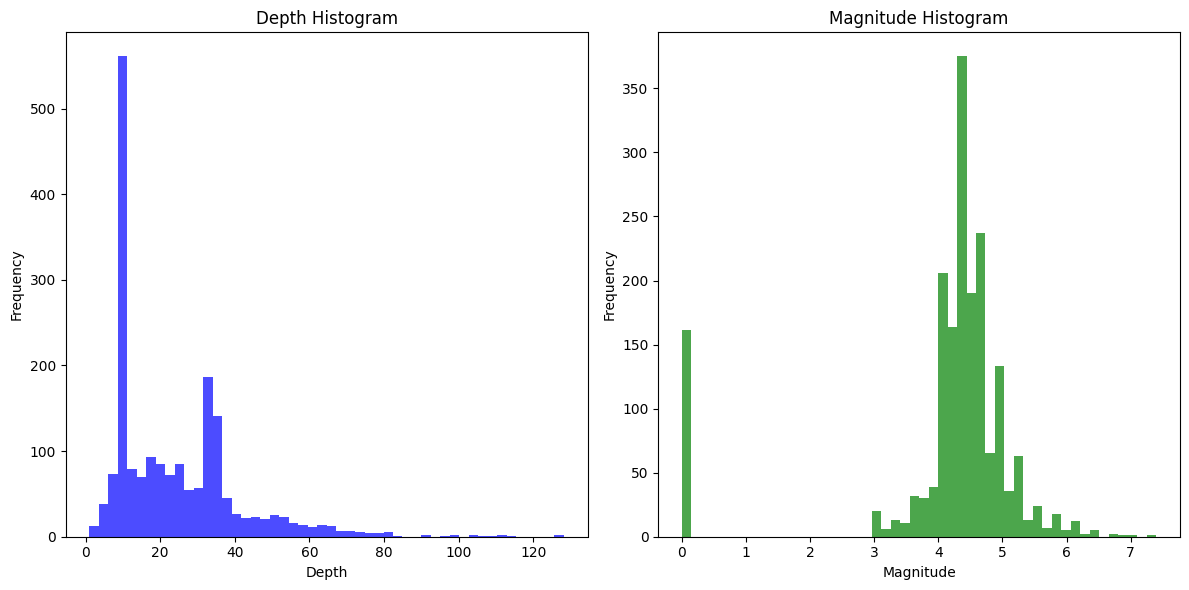

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for 'depth'
axes[0].hist(Taiwan_eq['depth'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Depth Histogram')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Frequency')

# Histogram for 'mag'
axes[1].hist(Taiwan_eq['mag'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Magnitude Histogram')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from 120.5 to 120
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 123.1 to 124
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 21.8 to 21
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 25.4 to 26


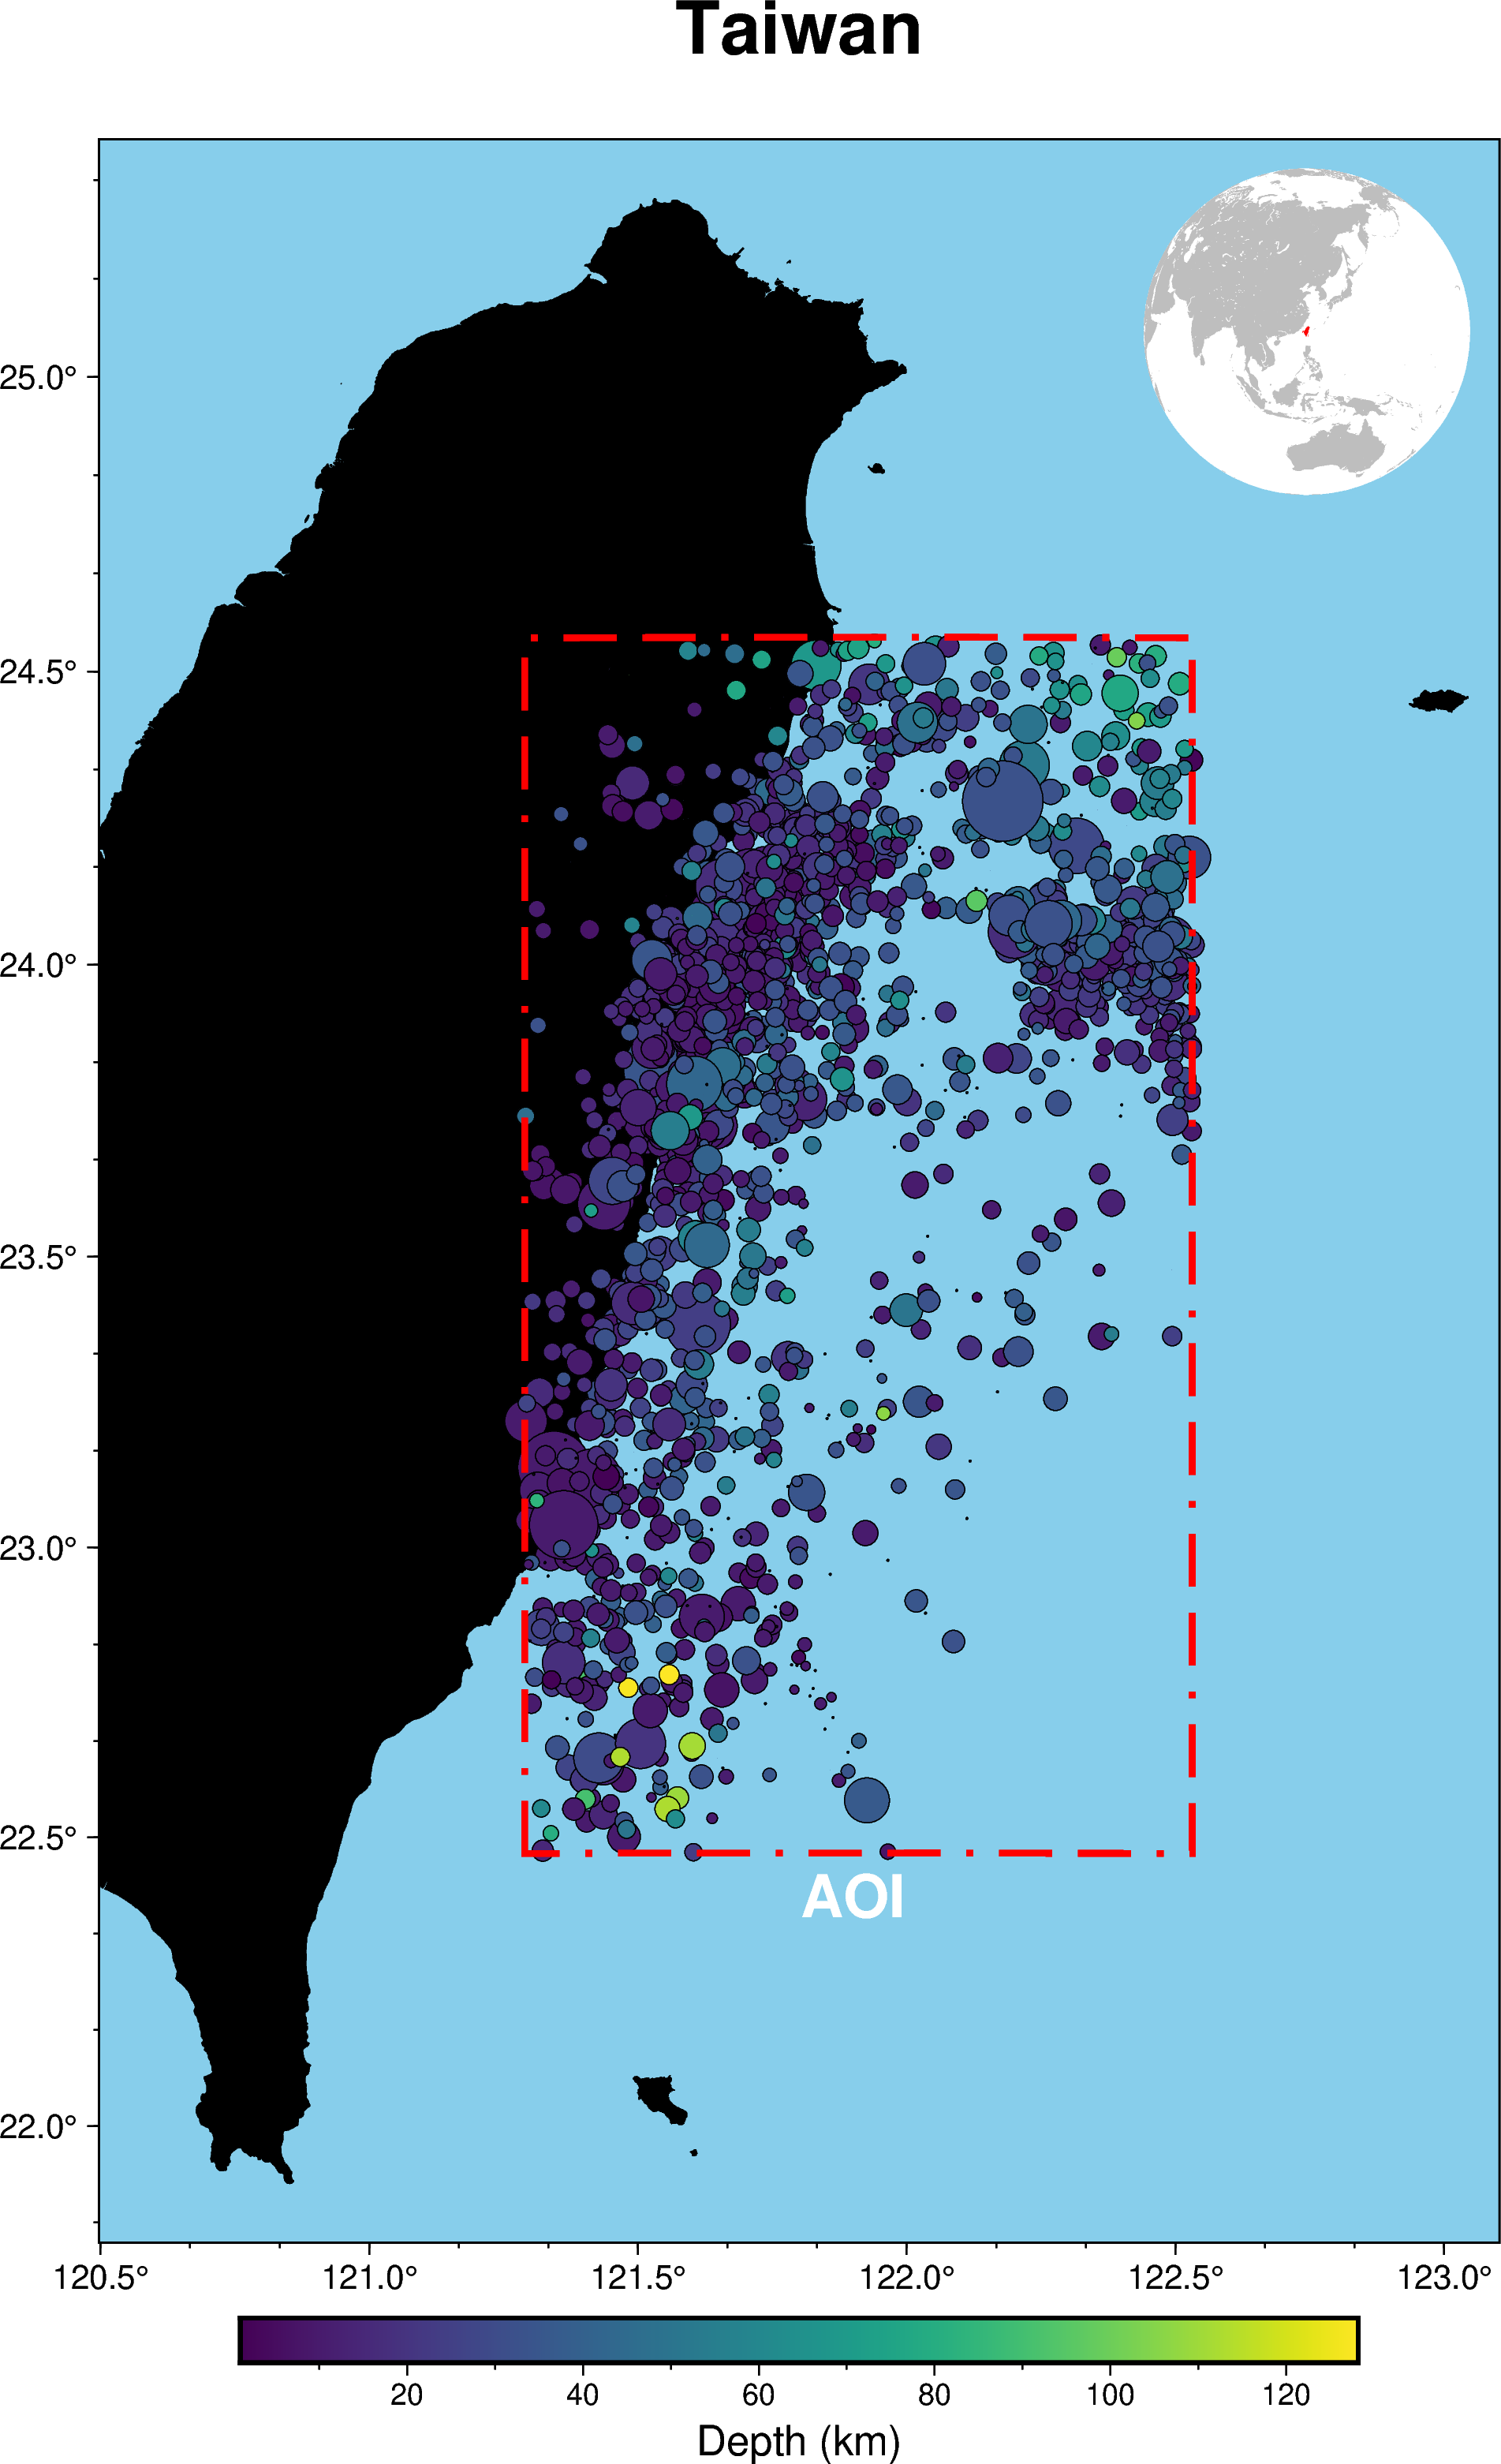

In [81]:
region = [120.5, 123.1, 21.8, 25.4]
grid = pygmt.datasets.load_earth_relief(resolution='01d', region=region)
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_eq['depth'].min(), Taiwan_eq['depth'].max()])
fig.plot(
    x=Taiwan_eq['longitude'],
    y=Taiwan_eq['latitude'], 
    size=0.02*(1.7**Taiwan_eq['mag']), 
    fill=Taiwan_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
fig.plot(
    projection="M15c",
    x=[121.289, 121.289, 122.531, 122.531,121.289],
    y=[22.472, 24.557, 24.557, 22.472, 22.472],
    pen="2p,red,-.-",
)
fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )
fig.show()

In [63]:
Taiwan_big_eq = Taiwan_eq[Taiwan_eq['mag'] >= 6.0]

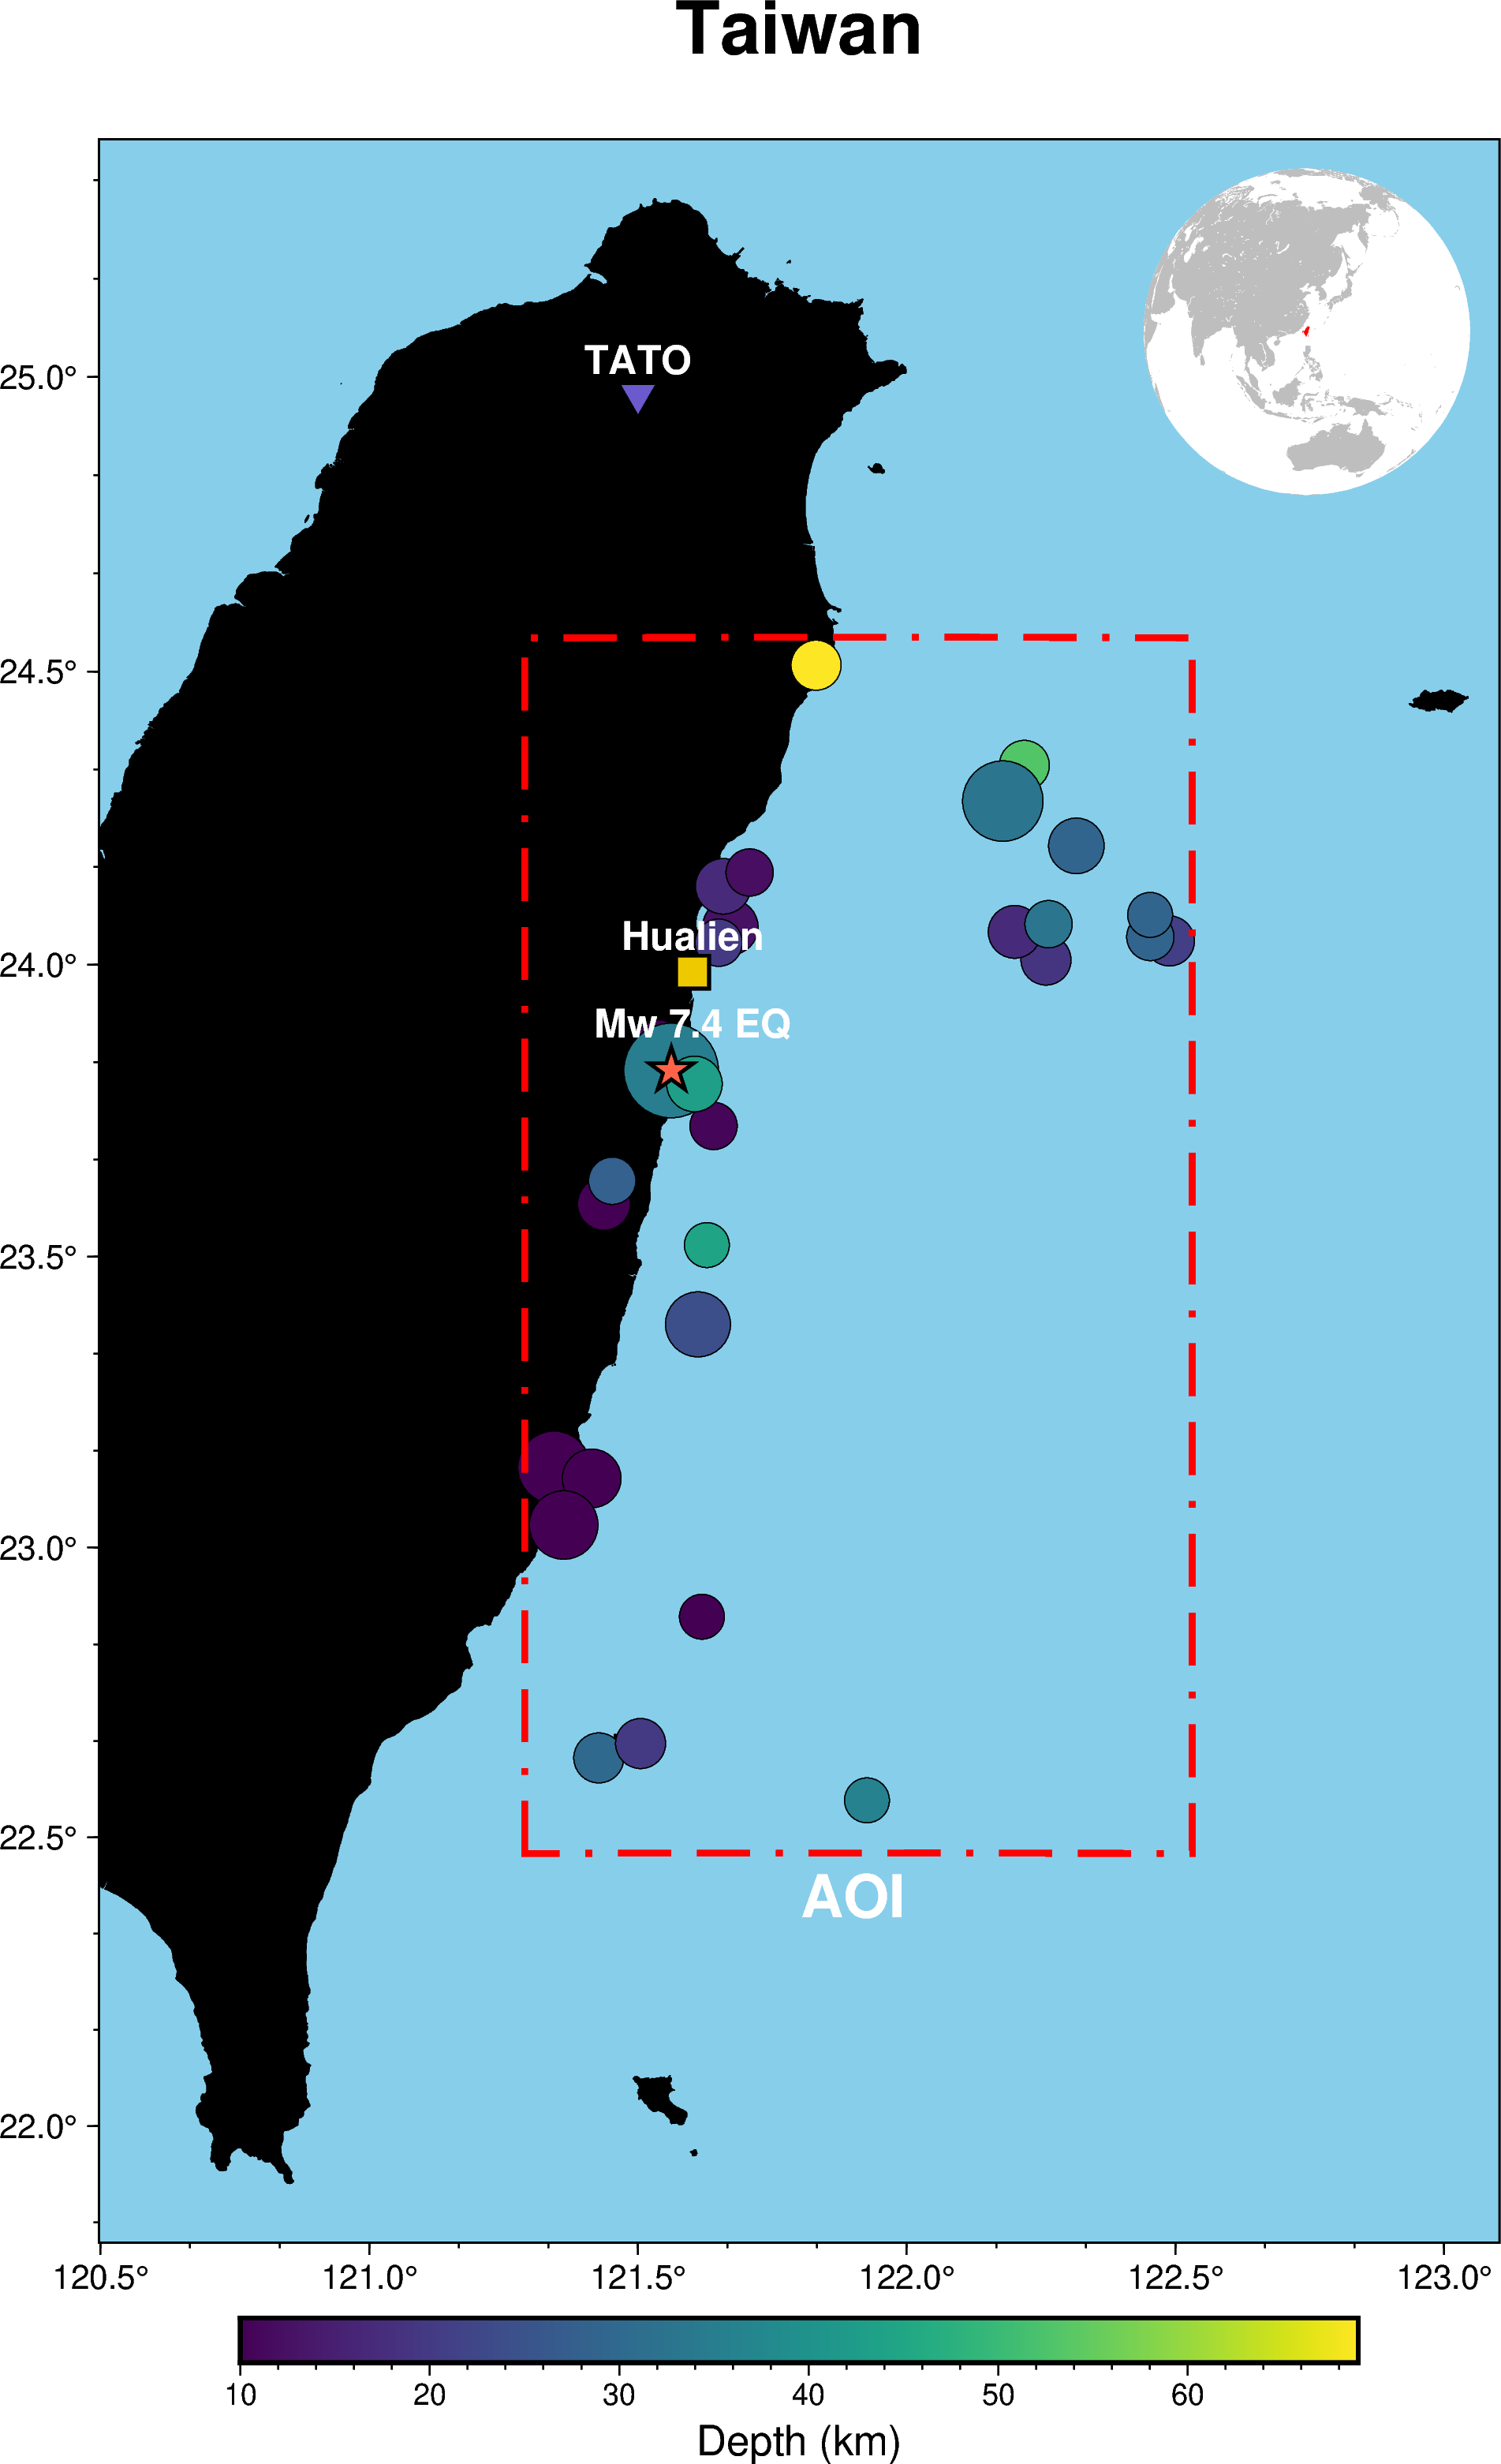

In [89]:
region = [120.5, 123.1, 21.8, 25.4]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_big_eq['depth'].min(), Taiwan_big_eq['depth'].max()])
fig.plot(
    x=Taiwan_big_eq['longitude'],
    y=Taiwan_big_eq['latitude'], 
    size=0.02*(1.7**Taiwan_big_eq['mag']), 
    fill=Taiwan_big_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
fig.plot(
    projection="M15c",
    x=[121.289, 121.289, 122.531, 122.531,121.289],
    y=[22.472, 24.557, 24.557, 22.472, 22.472],
    pen="2p,red,-.-",
)
fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )

fig.plot(x=121.50, y=24.97, style="i0.5c", pen="1p,black", fill="slateblue")
fig.text(text="TATO",x=121.50, y=25.03, font='12p,Helvetica-Bold,white')
fig.plot(x=121.6016, y=23.9872, style="s0.5c", pen="1p,black", fill="gold2")
fig.text(text="Hualien",x=121.6016, y=24.05, font='12p,Helvetica-Bold,white')
fig.plot(x=121.562, y=23.819, style="a0.5c", pen="1p,black", fill="tomato")
fig.text(text="Mw 7.4 EQ",x=121.6016, y=23.9, font='12p,Helvetica-Bold,white')
fig.show()